### Step 1.1: Import Libraries
We load all necessary Python libraries to work with 3D medical imaging, including file handling, numerical processing, and visualization.

In [ ]:
# Basic Imports and Setup
#!/usr/bin/env python3

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#make plots inline for Jupyter
%matplotlib inline

### Step 1.2: Define Data Path and Load NIfTI File

We load a FLAIR modality MRI volume using nibabel, and convert it into a NumPy array for analysis and visualization. We also extract the affine matrix, which contains spatial information about the image in real-world coordinates (e.g. mm in scanner space).


In [ ]:
# Define sample FLAIR file path (can later generalize to load all modalities)
sample_id = "BraTS20_Validation_001"
modality = "flair"
data_dir = "../data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

# Check if the data directory exists
nii_file = os.path.join(data_dir, sample_id, f"{sample_id}_{modality}.nii")

# Load NIfTI file using nibabel
img = nib.load(nii_file)
data = img.get_fdata()
affine = img.affine

# Diagnostics on the file etc. 
print(f"Shape: {data.shape}")
print(f"Voxel intensity range: {np.min(data):.2f} to {np.max(data):.2f}")


Shape: (240, 240, 155)
Voxel intensity range: 0.00 to 872.00


### Step 1.3: Normalize Intensities to [0, 1]

MRI scans can have wildly different intensity ranges depending on the scanner, patient, and sequence. We scale voxel values to the [0, 1] range using min-max normalization, both for interpretability and performance.

This step wasn’t something i was struggling with for a while — I had to test multiple workbooks and approaches to find a clean solution. It’s also a good reminder of how data preparation directly affects UX when visualizing or modeling.

This step standardizes brightness values, which:
- Helps machine learning models generalize better
- akes visualizations more comparable across scans
- Avoids crashing or freezing from trying to plot extreme intensity spikes (as I discovered when testing on my M1 chip!)

In [ ]:
def normalize_volume(volume):
    return (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

normalized_data = normalize_volume(data)

print(f"Normalized range: {np.min(normalized_data):.2f} to {np.max(normalized_data):.2f}")


Normalized range: 0.00 to 1.00


### Step 1.4: Threshold and Subsample

We remove low-intensity (near-zero) voxels — these typically correspond to background space (air or scanner padding) — which would otherwise clutter the plot. We also subsample every 2nd voxel along each axis to reduce rendering load.

In [ ]:
# Threshold to suppress background noise
threshold = 0.1
thresholded = normalized_data > threshold

# Subsample for fast plotting
subsample = (slice(None, None, 2), slice(None, None, 2), slice(None, None, 2))
mask = thresholded[subsample]
vol = normalized_data[subsample]

# Get voxel positions and intensities
x, y, z = np.where(mask)
intensities = vol[x, y, z]

print(f"Voxels retained after thresholding and subsampling: {len(x)}")


Voxels retained after thresholding and subsampling: 185787


### Step 1.5: Quick 3D Scatter3D Visualization

We plot the 3D brain structure using Plotly's Scatter3d, which is fast and lightweight for rendering voxel clouds. Each point corresponds to a voxel above the intensity threshold.

You should see the outer contour of the brain and possibly some internal density changes.

If nothing shows up or the plot is blank, it likely means the threshold was too high or normalization failed — this plot serves as a real-time check.

In [ ]:
fig = go.Figure(data=go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=1.5,
        color=intensities,
        colorscale='Viridis',
        opacity=0.6
    )
))

fig.update_layout(
    title=f"3D MRI Scan (FLAIR) - {sample_id}",
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


### Final Summary (Markdown Cell for End of Section)

In this section, I built a basic 3D brain visualization pipeline using a FLAIR scan from the BraTS2020 dataset. I loaded and normalized the data, removed low-intensity voxels, and created a sparse 3D visualization using Plotly. This not only helps validate data quality but sets the foundation for deeper analysis and segmentation modeling.
In practice, this step reveals challenges like rendering speed, image noise, and voxel range variability — all of which are essential considerations when building deployable medical AI systems.

# EDA
### 2.1: Load All Modalities for One Subject

Each modality captures different tissue characteristics, so visualizing them together allows:

- Better anatomical understanding of the brain
- Insights into how tumors appear across contrasts
- Groundwork for multi-channel model input

Radiologists use multiple modalities because tumors behave differently across contrasts. For instance:

- T1ce enhances active tumor regions
- FLAIR highlights tumor surroundings (edema)
- T2 is sensitive to fluid accumulation

Understanding these distinctions helps model design (e.g., stacking inputs across modalities).

In [32]:
# Load all 4 modalities for a sample subject
modalities = ['t1', 't1ce', 't2', 'flair']
sample_id = "BraTS20_Validation_001"
data_dir = "../data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

def load_modalities(subject_id, modalities):
    subject_path = os.path.join(data_dir, subject_id)
    volumes = {}
    for mod in modalities:
        path = os.path.join(subject_path, f"{subject_id}_{mod}.nii")
        img = nib.load(path)
        volumes[mod] = img.get_fdata()
    return volumes

volumes = load_modalities(sample_id, modalities)


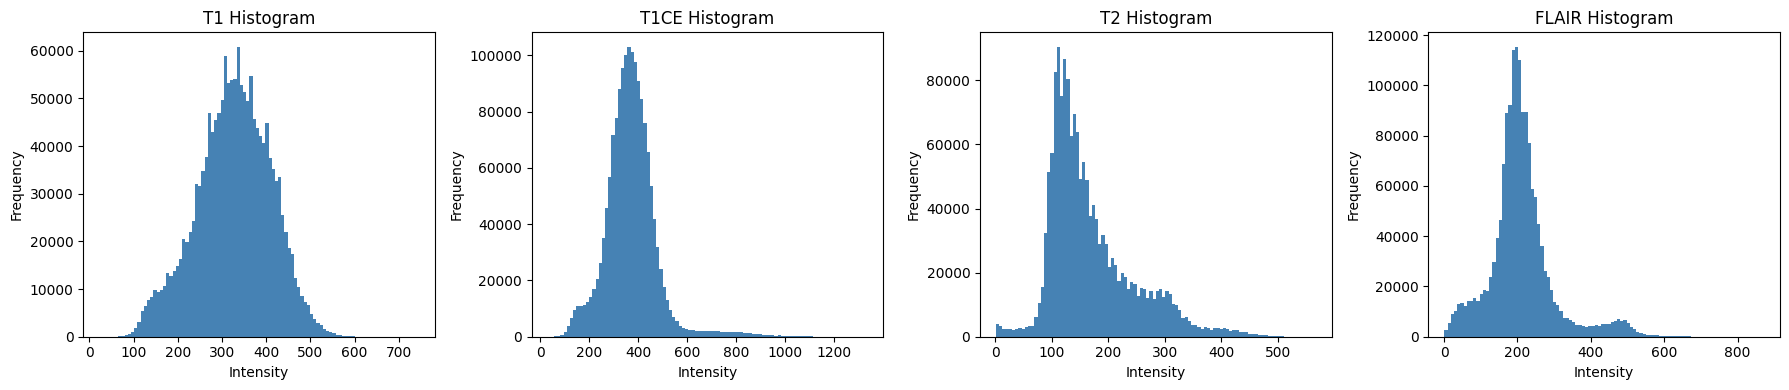

In [33]:
# Plot intensity distributions to understand modality differences
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for i, mod in enumerate(modalities):
    data = volumes[mod]
    axes[i].hist(data[data > 0].ravel(), bins=100, color='steelblue')
    axes[i].set_title(f"{mod.upper()} Histogram")
    axes[i].set_xlabel("Intensity")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


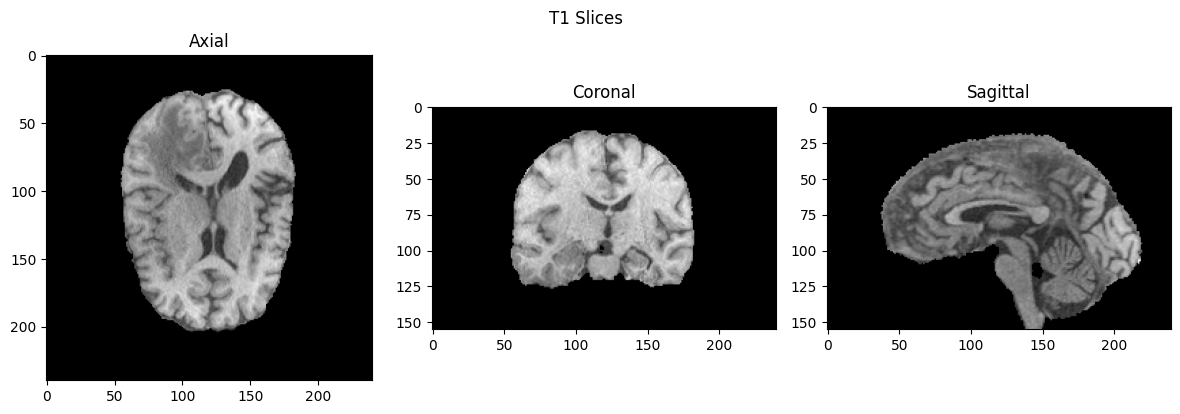

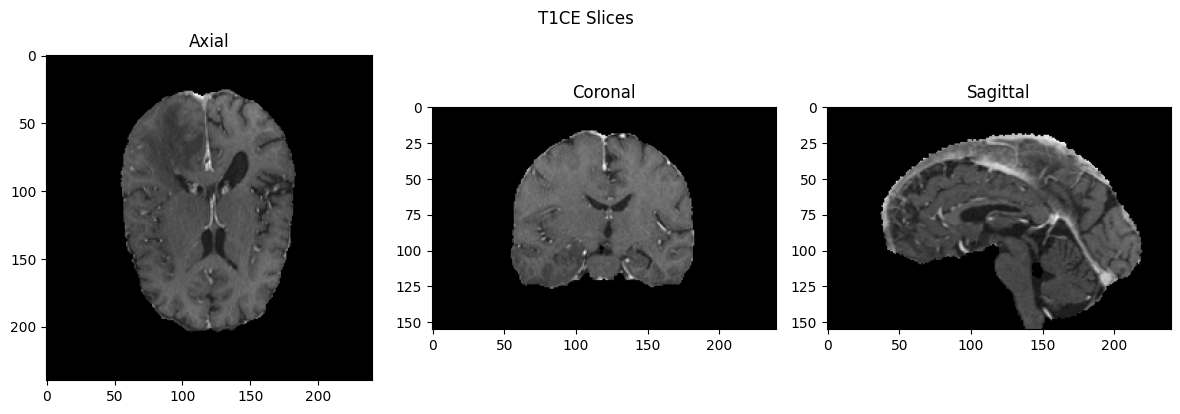

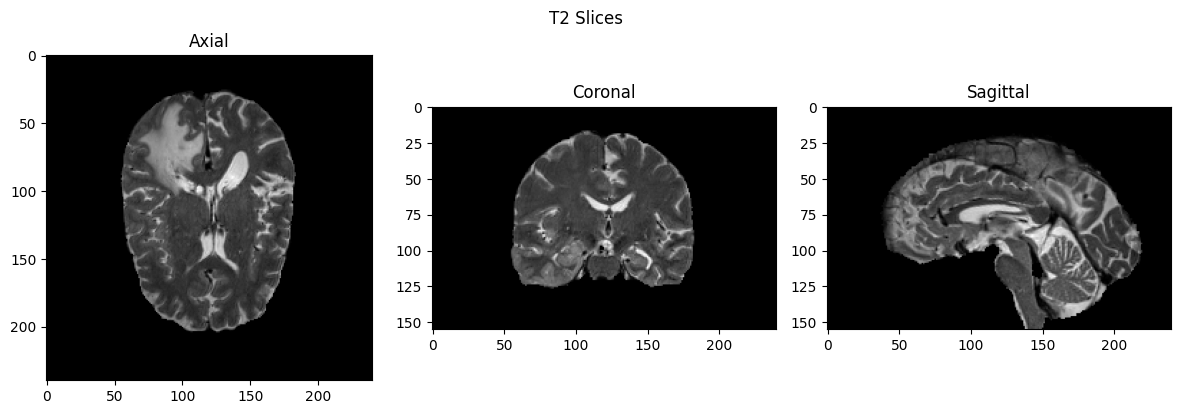

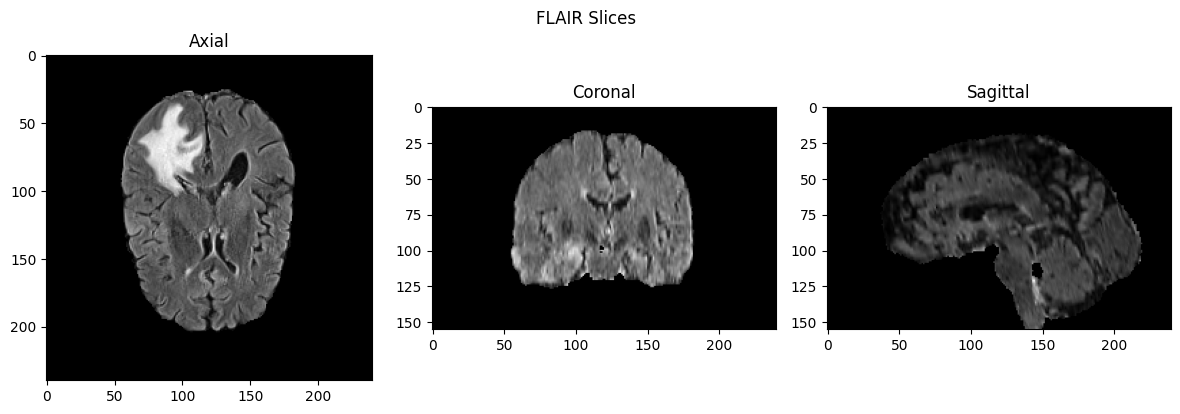

In [34]:
# Show middle slice along 3 axes for each modality
def show_slices(volume, title, cmap='gray'):
    mid_slices = [s//2 for s in volume.shape]
    axial = volume[:, :, mid_slices[2]]
    coronal = volume[:, mid_slices[1], :]
    sagittal = volume[mid_slices[0], :, :]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(np.rot90(axial), cmap=cmap)
    axes[0].set_title('Axial')
    axes[1].imshow(np.rot90(coronal), cmap=cmap)
    axes[1].set_title('Coronal')
    axes[2].imshow(np.rot90(sagittal), cmap=cmap)
    axes[2].set_title('Sagittal')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display for each modality
for mod in modalities:
    show_slices(volumes[mod], f"{mod.upper()} Slices")
